In [ ]:
# Imports
library(Seurat)
library(ggplot2)
library(stringr) 
library(dplyr)
library(tibble)
library(tidyr)
library(patchwork)
library(ggplot2)
library(pheatmap)
library(clusterProfiler)
library(org.Mm.eg.db)
library(fgsea)
library(msigdbr)
library(homologene)
library(readxl)
library(gridExtra)
library(grid)

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=20, repr.plot.height=12)

# Read macrophage subsets
macrophages_m <- readRDS("../../../data/R Objects/Macrophage R Objects/all_mice_macrophage_data_annotatedv2.rds")
macrophages_h <- readRDS("../../../data/R Objects/Macrophage R Objects/all_humans_macrophage_data_annotatedv2.rds")

In [ ]:
# View amount of mouse macrophag cells
ncol(macrophages_m)

[1] 1464

In [ ]:
# Reset identities, as identities were corrected after expert opinion
macrophages_m <- SetIdent(macrophages_m, value = "seurat_clusters")
macrophages_m <- RenameIdents(macrophages_m,
                                   '0' = 'Inflammatory macrophages',
                                   '1' = 'Resident-like macrophages',
                                   '2' = 'Inflammatory macrophages',
                                   '3' = 'Inflammatory macrophages',
                                   '4' = 'Resident-like macrophages',
                                   '5' = 'LAMs',
                                   '6' = 'iLAMs', 
                                   '7' = 'Inflammatory macrophages',
                                   '8' = 'LAMs',
                                   '9' = 'Resident-like macrophages',
                                   '10' = 'LAMs',
                                   '11' = 'Inflammatory macrophages', 
                                   '12' = 'IFNIC macrophages')

# Assign new labels
macrophages_h <- SetIdent(macrophages_h, value = "seurat_clusters")
macrophages_h <- RenameIdents(macrophages_h,
                                   '0' = 'Inflammatory macrophages',  # was Inflammatory Resident-like
                                   '1' = 'Inflammatory macrophages',
                                   '2' = 'Inflammatory macrophages', 
                                   '3' = 'Resident-like macrophages',
                                   '4' = 'Resident-like macrophages',
                                   '5' = 'iLAMs',
                                   '6' = 'iLAMs',
                                   '7' = 'LAMs',
                                   '8' = 'Inflammatory macrophages', # was Inflammatory Resident-like
                                   '9' = 'IFNIC macrophages',
                                   '10' = 'LAMs',
                                   '11' = 'LAMs',
                                   '12' = 'iLAMs',
                                   '13' = 'Proliferating macrophages')

In [ ]:
# Filter on > 3 cells
macrophages_filtered <- lapply(list(macrophages_m, macrophages_h), function(macrophages) {
    num.cells <- rowSums(macrophages[["RNA"]]$counts>0) 
    genes.selected <- names(which(num.cells >= 3))
    return(subset(macrophages, features = genes.selected)) })

# Assign
macrophages_m2 <- macrophages_filtered[[1]]
macrophages_h2 <- macrophages_filtered[[2]]

In [18]:
# Find markers for each organism
markers_m2 <- FindAllMarkers(macrophages_m2, only.pos = FALSE, return.thresh = 1, logfc.threshold = 0)
markers_h2 <- FindAllMarkers(macrophages_h2, only.pos = FALSE, return.thresh = 1, logfc.threshold = 0)

Calculating cluster Inflammatory macrophages

Calculating cluster Resident-like macrophages

Calculating cluster LAMs

Calculating cluster iLAMs

Calculating cluster IFNIC macrophages

Calculating cluster Inflammatory macrophages

Calculating cluster Resident-like macrophages

Calculating cluster iLAMs

Calculating cluster LAMs

Calculating cluster IFNIC macrophages

Calculating cluster Proliferating macrophages



In [ ]:
# Get SynGO mappings
SynGO_map <- read_excel("idmap.xlsx")[, c("query", "entrezgene")]
head(SynGO_map)

query  entrezgene
1 A1BG   1         
2 A2M    2         
3 AAAS   8086      
4 AAK1   22848     
5 AAMP   14        
6 AARSD1 80755

In [ ]:
# Merge mouse and human markers based on homologs
# First, merge SynGO marker genes to find entrez ID
markers_h2 <- merge(markers_h2, SynGO_map, by.x = "gene", by.y = "query", all.x = TRUE)

# Convert mouse to human homologs
mouse_homologs <- mouse2human(rownames(markers_m2), db = homologene::homologeneData)

# Merge mouse and human based on entrez ID
markers_h2 <- merge(markers_h2, mouse_homologs, by.x = "entrezgene", by.y = "humanID")

# Combine markers based on mouse genes & same cell-type
markers_combined <- merge(markers_m2, markers_h2, by.x = c("gene", "cluster"), by.y = c("mouseGene", "cluster"), all.x = TRUE)

# Get object without NA values (unmappable genes)
markers_combined_noNA <- subset(markers_combined, subset = gene.y != "NA")

# Get object with only NA values (unmappable genes)
markers_combined_NAs <- subset(markers_combined, subset = is.na(gene.y))

In [ ]:
# Find differences between expression percentages (mouse vs human) 
markers_combined_noNA$pct.1.diff <- (markers_combined_noNA$pct.1.x + markers_combined_noNA$pct.1.y)/2

# Find differences between log2FC values of markers (mouse vs human)
markers_combined_noNA$log2FC.diff <- markers_combined_noNA$avg_log2FC.y - markers_combined_noNA$avg_log2FC.x

In [ ]:
# Define which subtypes to compare
subtypes_to_compare <- c("Resident-like macrophages", "LAMs", "iLAMs", "IFNIC macrophages", "Inflammatory macrophages")

# Visualize the logfold differences & pct.1 differences
cowplots_genes <- lapply(subtypes_to_compare, function(subtype) {
    sub <- subset(markers_combined_noNA, subset = cluster == subtype)
    p <- ggplot(sub, aes(x = pct.1.diff, y = log2FC.diff)) +  # x-axis = column2, y-axis = column1
    geom_point(aes(alpha = abs(log2FC.diff) >= 2 & pct.1.diff > 0.3), size = 4, color = "navy") + 
    scale_alpha_manual(values = c(0.1, 1)) +  # Transparent (0.1) below cutoff, fully visible (1) above 
    geom_text_repel(aes(label = ifelse(abs(log2FC.diff) >= 2 & pct.1.diff > 0.3, gene.y, "")), hjust = -0.3, vjust = 0.5, size = 14) +  # Labels show only if above cutoff 
    theme_minimal() + 
    geom_hline(yintercept = c(-2, 2), linetype = "dashed", color = "red", size = 0.75) +
    geom_vline(xintercept = 0.3, linetype = "dashed", color = "red", size = 0.75) +
    labs(x = sprintf("Mean expression percentage of mouse and human %s", subtype), y = "Difference between log2FC values", title = sprintf("Differentially expressed genes in macrophages of mouse and human %s", subtype)) +
    theme(
        axis.title.x = element_text(size = 32),
        axis.title.y = element_text(size = 32),
        plot.title = element_blank(),
        axis.text = element_text(size = 24),
        legend.position = "none"
        )
    return(p)
})

In [ ]:
# Feature plot LYZ & LGALS2
features_plots <- c("LYZ", "LGALS2")

In [ ]:
# Sort mappable mouse markers on descending pct.1. of mice & filtere on Log2FC > 1
na_markers_sorted <- markers_combined_NAs %>% arrange(desc(pct.1.x)) %>% filter(abs(avg_log2FC.x) > 1)

In [96]:
# Plot of subtypes of non-mappable genes
NA_genes <- lapply(subtypes_to_compare, function(subtype) {
    sub <- subset(na_markers_sorted, subset = cluster == subtype)
    p <- ggplot(sub, aes(x = pct.1.x, y = avg_log2FC.x)) +  # x-axis = column2, y-axis = column1
    geom_point(aes(alpha = abs(avg_log2FC.x) >= 2 & pct.1.x > 0.5), size = 4, color = "navy") + 
    scale_alpha_manual(values = c(0.1, 1)) +  
    geom_text_repel(aes(label = ifelse(abs(avg_log2FC.x) >= 2 & pct.1.x > 0.5, gene, "")), hjust = -0.3, vjust = 0.5, size = 14,
    point.padding = .3,
    max.overlaps = Inf,) +  # Labels only if above cutoff +
    geom_hline(yintercept = c(-2, 2), linetype = "dashed", color = "red", size = 0.75) +
    geom_vline(xintercept = 0.5, linetype = "dashed", color = "red", size = 0.75) +
    theme_minimal() + 
    labs(x = sprintf("Mean expression percentage of mouse %s", subtype), y = "Log2FC values", title = sprintf("Non mappable DE genes of mouse %s", subtype)) +
    theme(
        axis.title.x = element_text(size = 32),
        axis.title.y = element_text(size = 32),
        axis.text = element_text(size = 24),
        plot.title = element_blank(),
        legend.position = "none"
        )
    return(p)
})

Warning message:
"ggrepel: 33 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


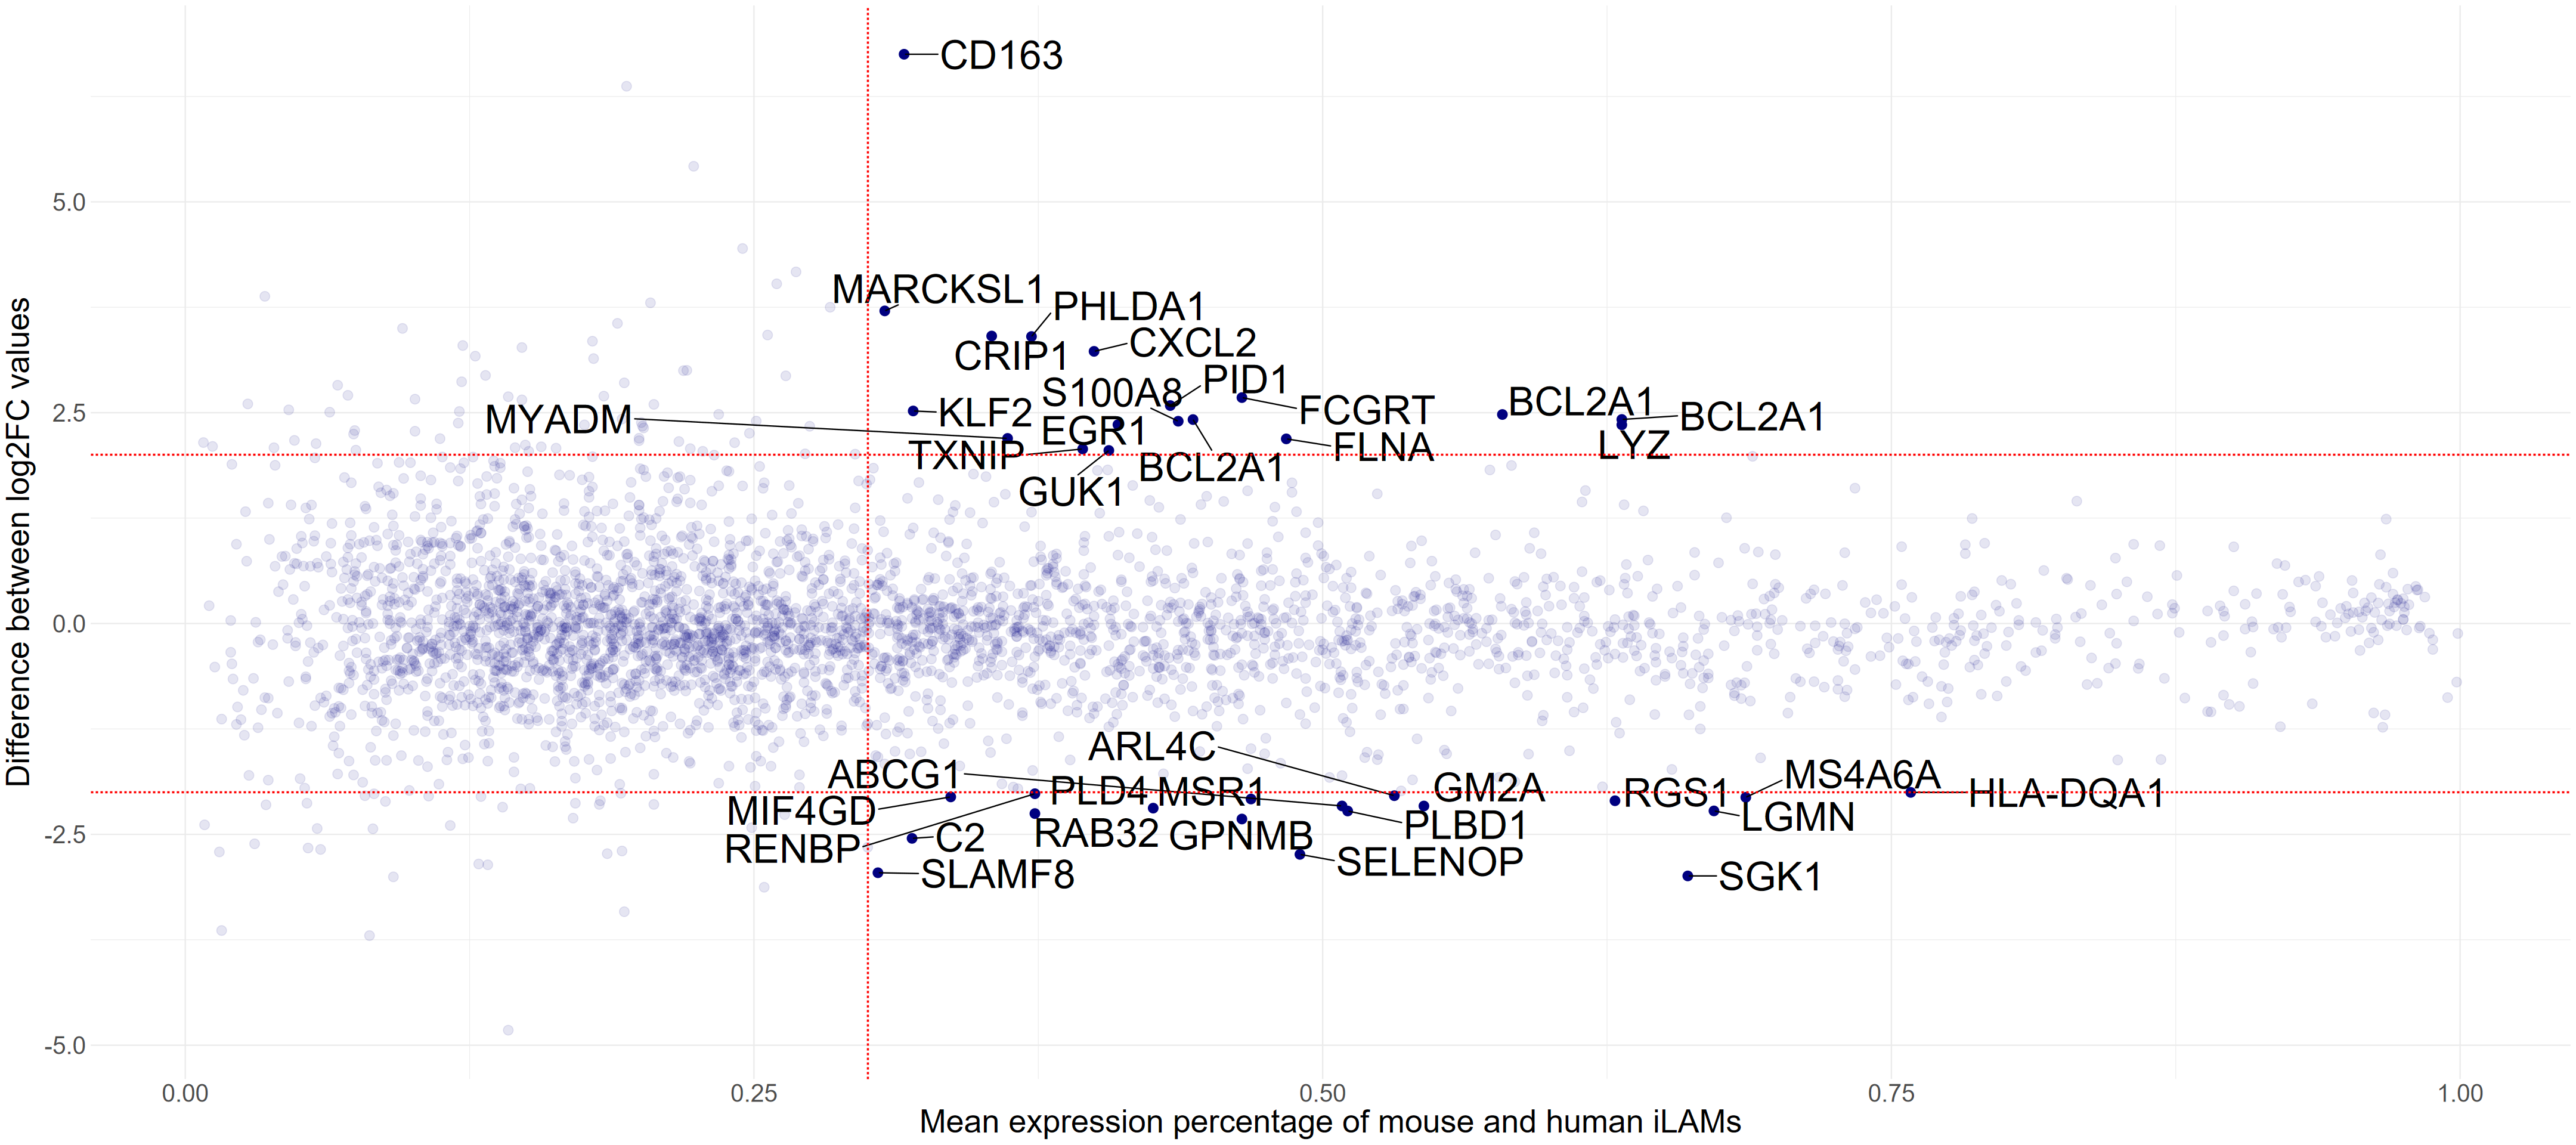

In [ ]:
# Example plot
cowplots_genes[[3]]

Warning message:
"ggrepel: 34 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


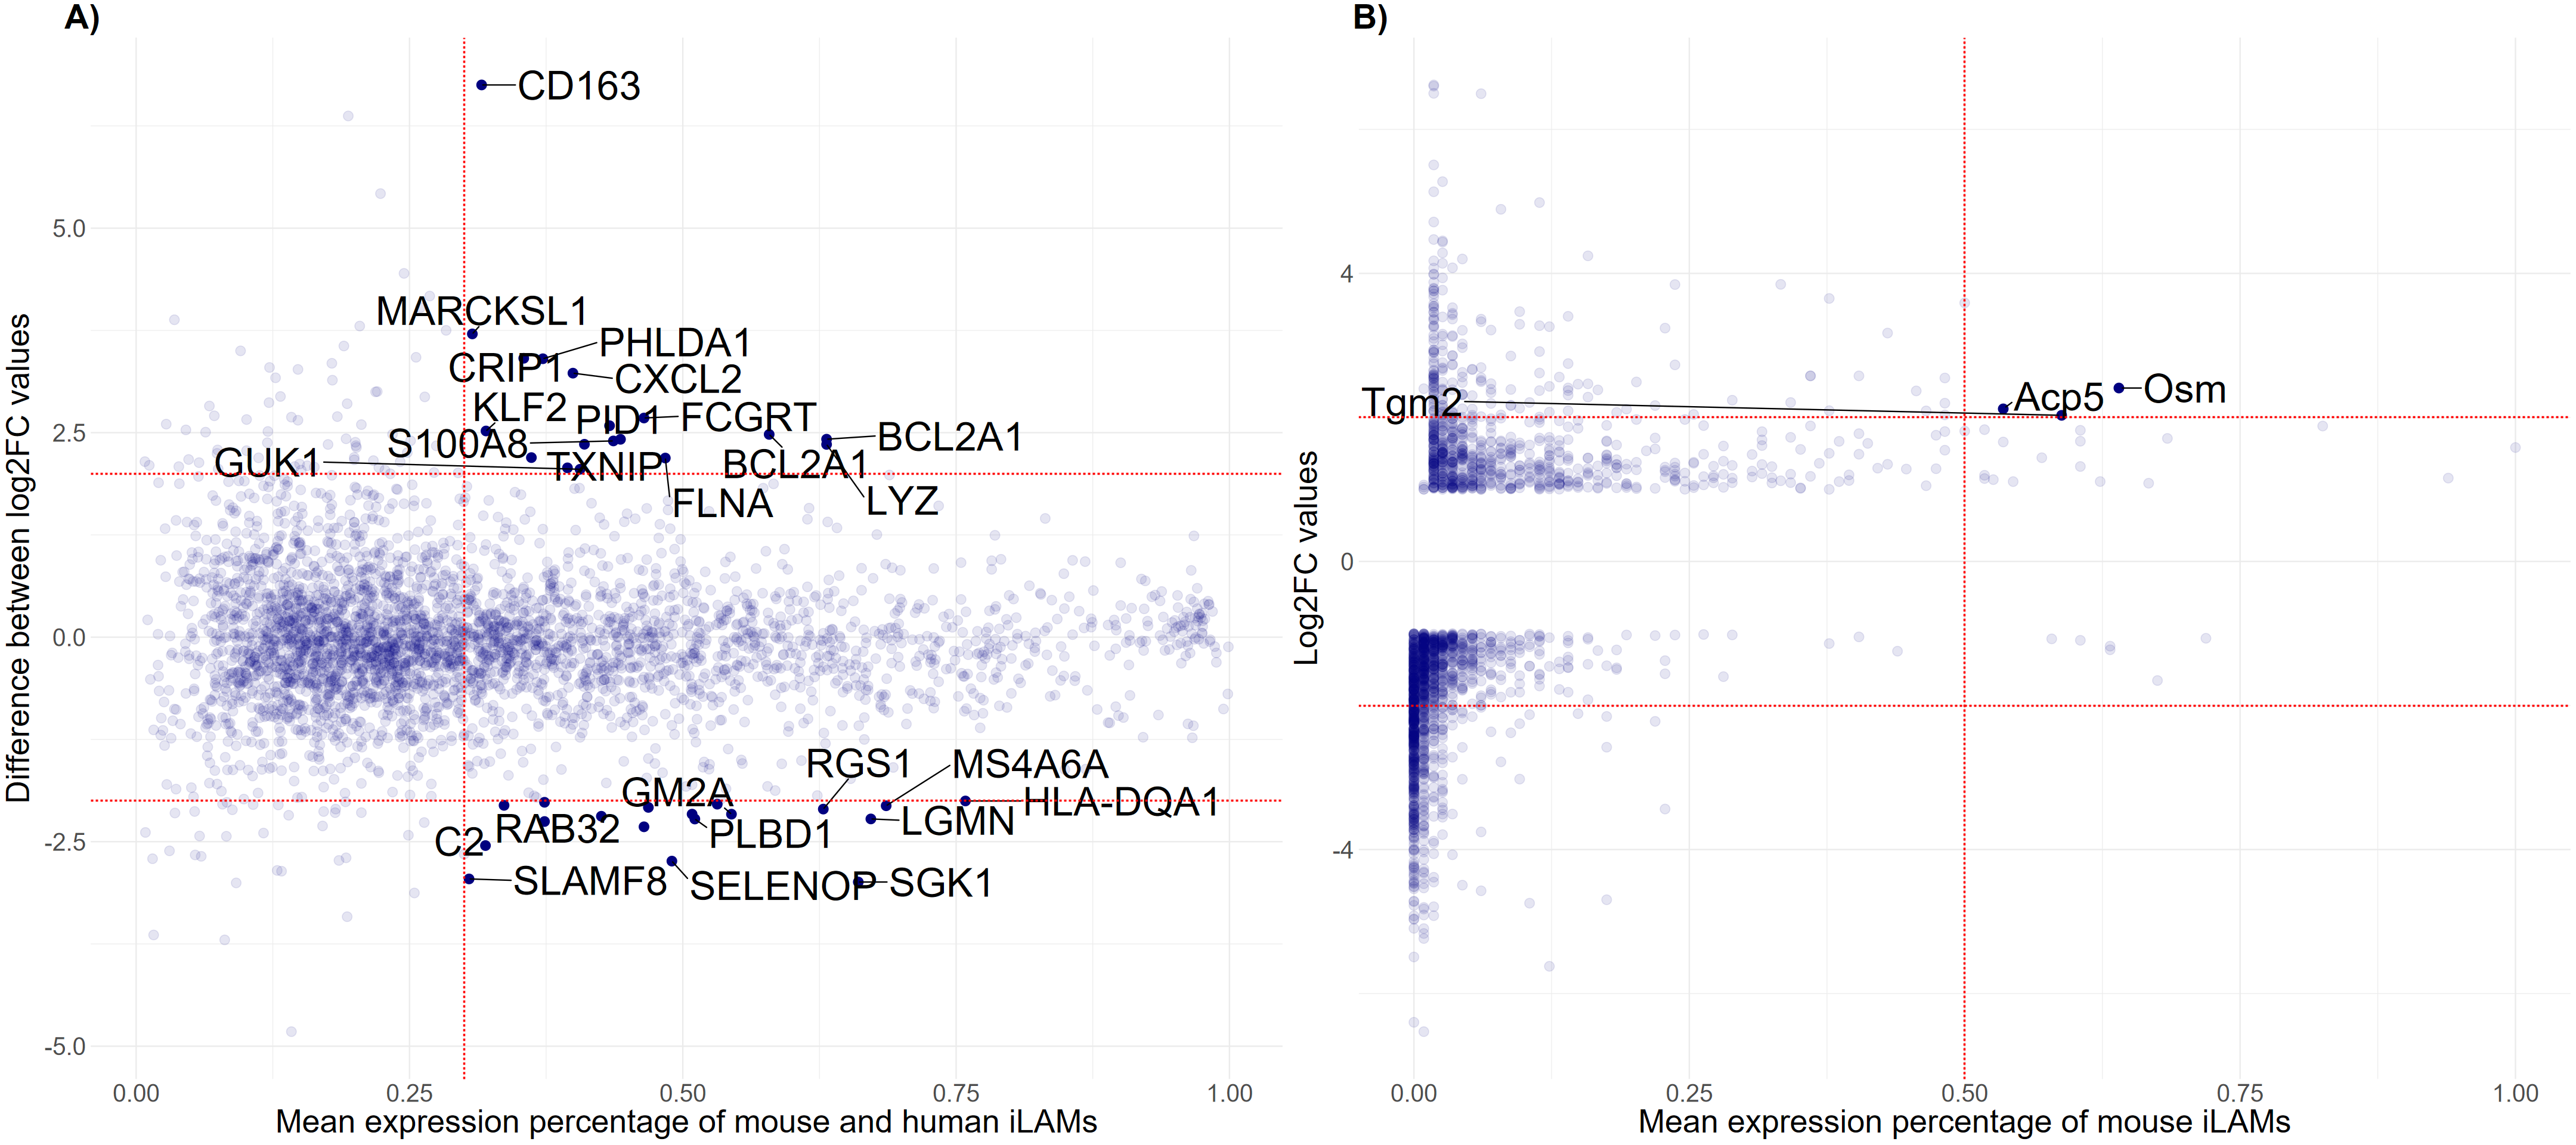

In [ ]:
# Change setting for visualizing plots within VSCODE
options(repr.plot.width=36, repr.plot.height=16)


# Define the layout matrix
layout_matrix <- rbind(
  c(1, 2))

# Change this number, to change subtype, where each number corresponds to index of: subtypes_to_compare <- c("Resident-like macrophages", "LAMs", "iLAMs", "IFNIC macrophages", "Inflammatory macrophages")
i <- 3

# Create plot of mappable genes
Cowplot_plot <- arrangeGrob(cowplots_genes[[i]], 
                                  top = textGrob("A)", x = unit(0.05, "npc"), just = "left", 
                                                 gp = gpar(fontsize = 34, fontface = "bold")))

# Create plot of unmppable genes
na_gene_plot <- arrangeGrob(NA_genes[[i]], 
                               top = textGrob("B)", x = unit(0.05, "npc"), just = "left", 
                                              gp = gpar(fontsize = 34, fontface = "bold")))

# plot in grid
grid.arrange(
  Cowplot_plot, na_gene_plot,
  layout_matrix = layout_matrix
)

Warning message in DoHeatmap(macrophages_h2, features = top10$gene, group.bar = TRUE, :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: TM6SF1, SAP30"


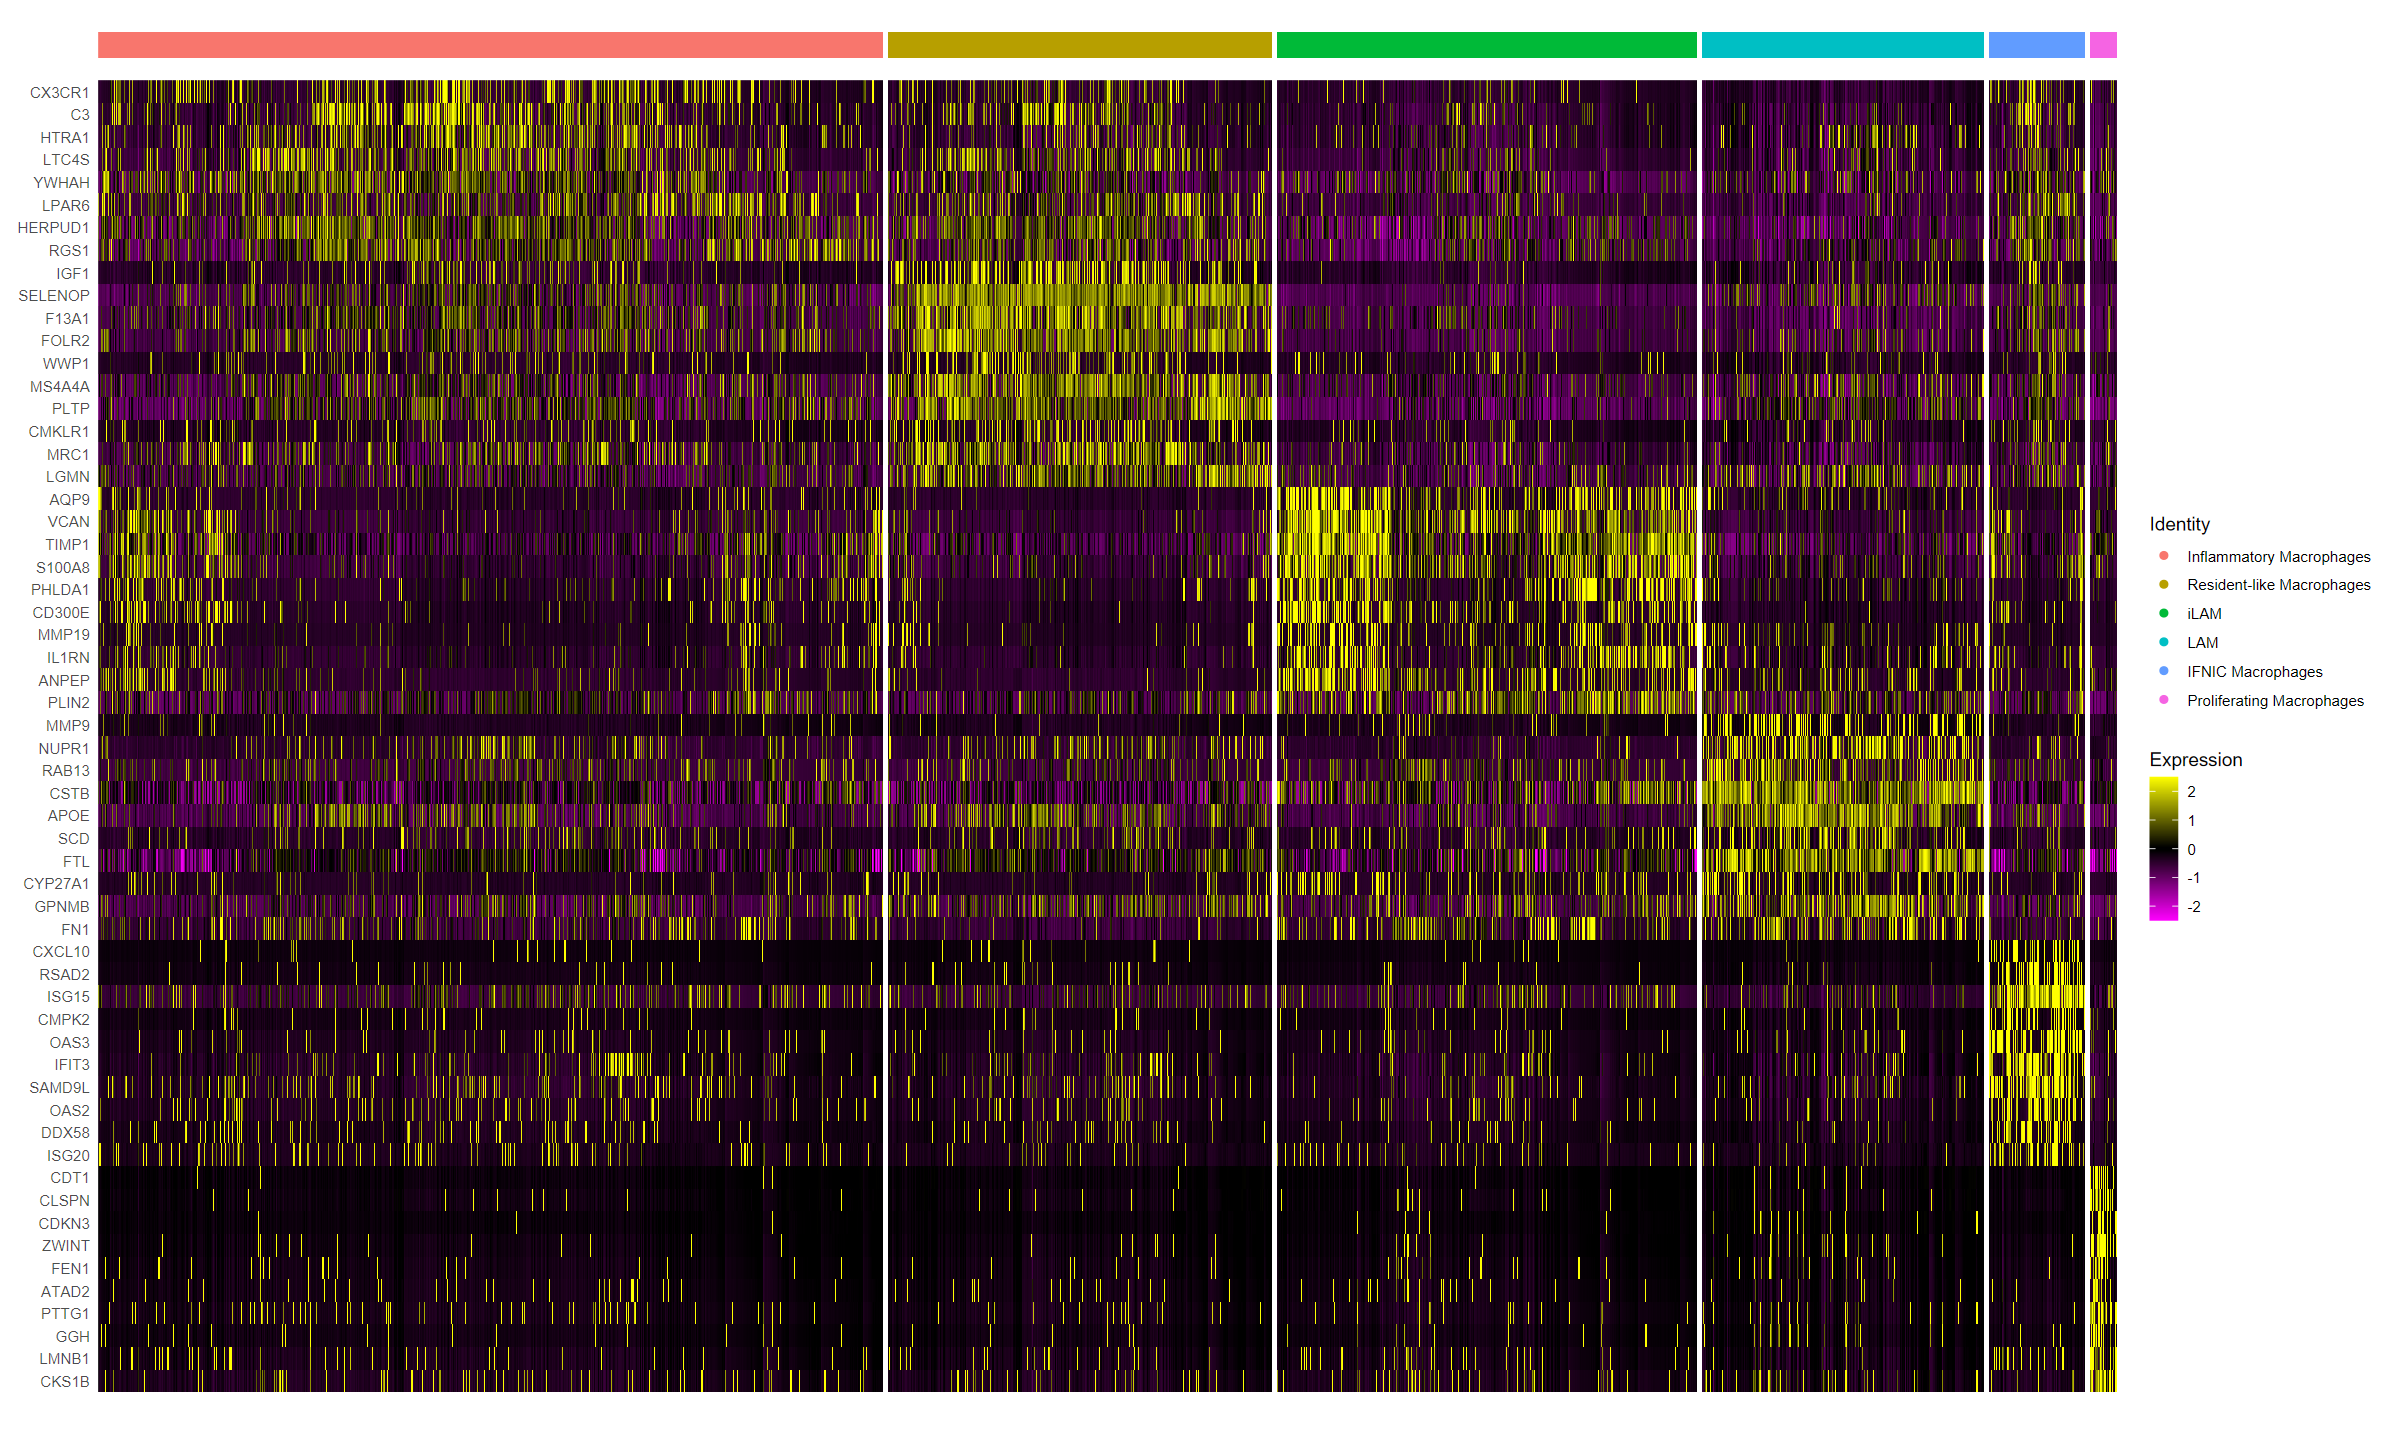

In [72]:
## Plot heatmap
markers_h2 %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) %>%
    dplyr::filter(avg_log2FC > .75, pct.1 > 0.3) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10
DoHeatmap(macrophages_h2, features = top10$gene, group.bar = TRUE, label = FALSE)

In [ ]:
# Known marker genes for each macrophag subtype
markers_resident <- c("LYVE1", "FOLR2", "C1QA", "CX3CR1", "SELENOP")
markers_ilams <- c("TREM1", "PLIN2", "CCL2", "CCL7", "VCAN")
markers_inflam <- c("S100A8", "S100A9", "NLRP3", "IL1B", "CXCL2")
markers_lams <- c("TREM2", "FABP5", "APOE", "CD9", "APOC1")
markers_IFNIC <- c("ISG15", "IRF7", "IFIT3", "IFIT1")
markers_proliferating <- c("STMN1", "TOP2A", "MKI67", "TUBA1B")

# Order: resident, inflammatory, LAM, iLAM, IFNIC, proliferating
known_markers_h <- c("LPL", "CD36", "FABP4", "LYVE1", "FOLR2", "C1QA", "CX3CR1", "SELENOP", "S100A8", "S100A9", "NLRP3", "IL1B", "CXCL2", "TREM2", "FABP5", "APOE", "CD9", "APOC1", "TREM1", "PLIN2", "CCL2", "CCL7", "VCAN", "ISG15", "IRF7", "IFIT3", "IFIT1", "STMN1", "TOP2A", "MKI67", "TUBA1B")

# Replace SELENOP to mouse homolog Sepp1
known_markers_m <- str_to_title(c("Abca1", "Id3", "Ear2", "LPL", "CD36", "FABP4", "LYVE1", "FOLR2", "C1QA", "CX3CR1", "Sepp1", "S100A8", "S100A9", "NLRP3", "IL1B", "CXCL2", "TREM2", "FABP5", "APOE", "CD9", "APOC1", "TREM1", "PLIN2", "CCL2", "CCL7", "VCAN", "ISG15", "IRF7", "IFIT3", "IFIT1", "STMN1", "TOP2A", "MKI67", "TUBA1B"))

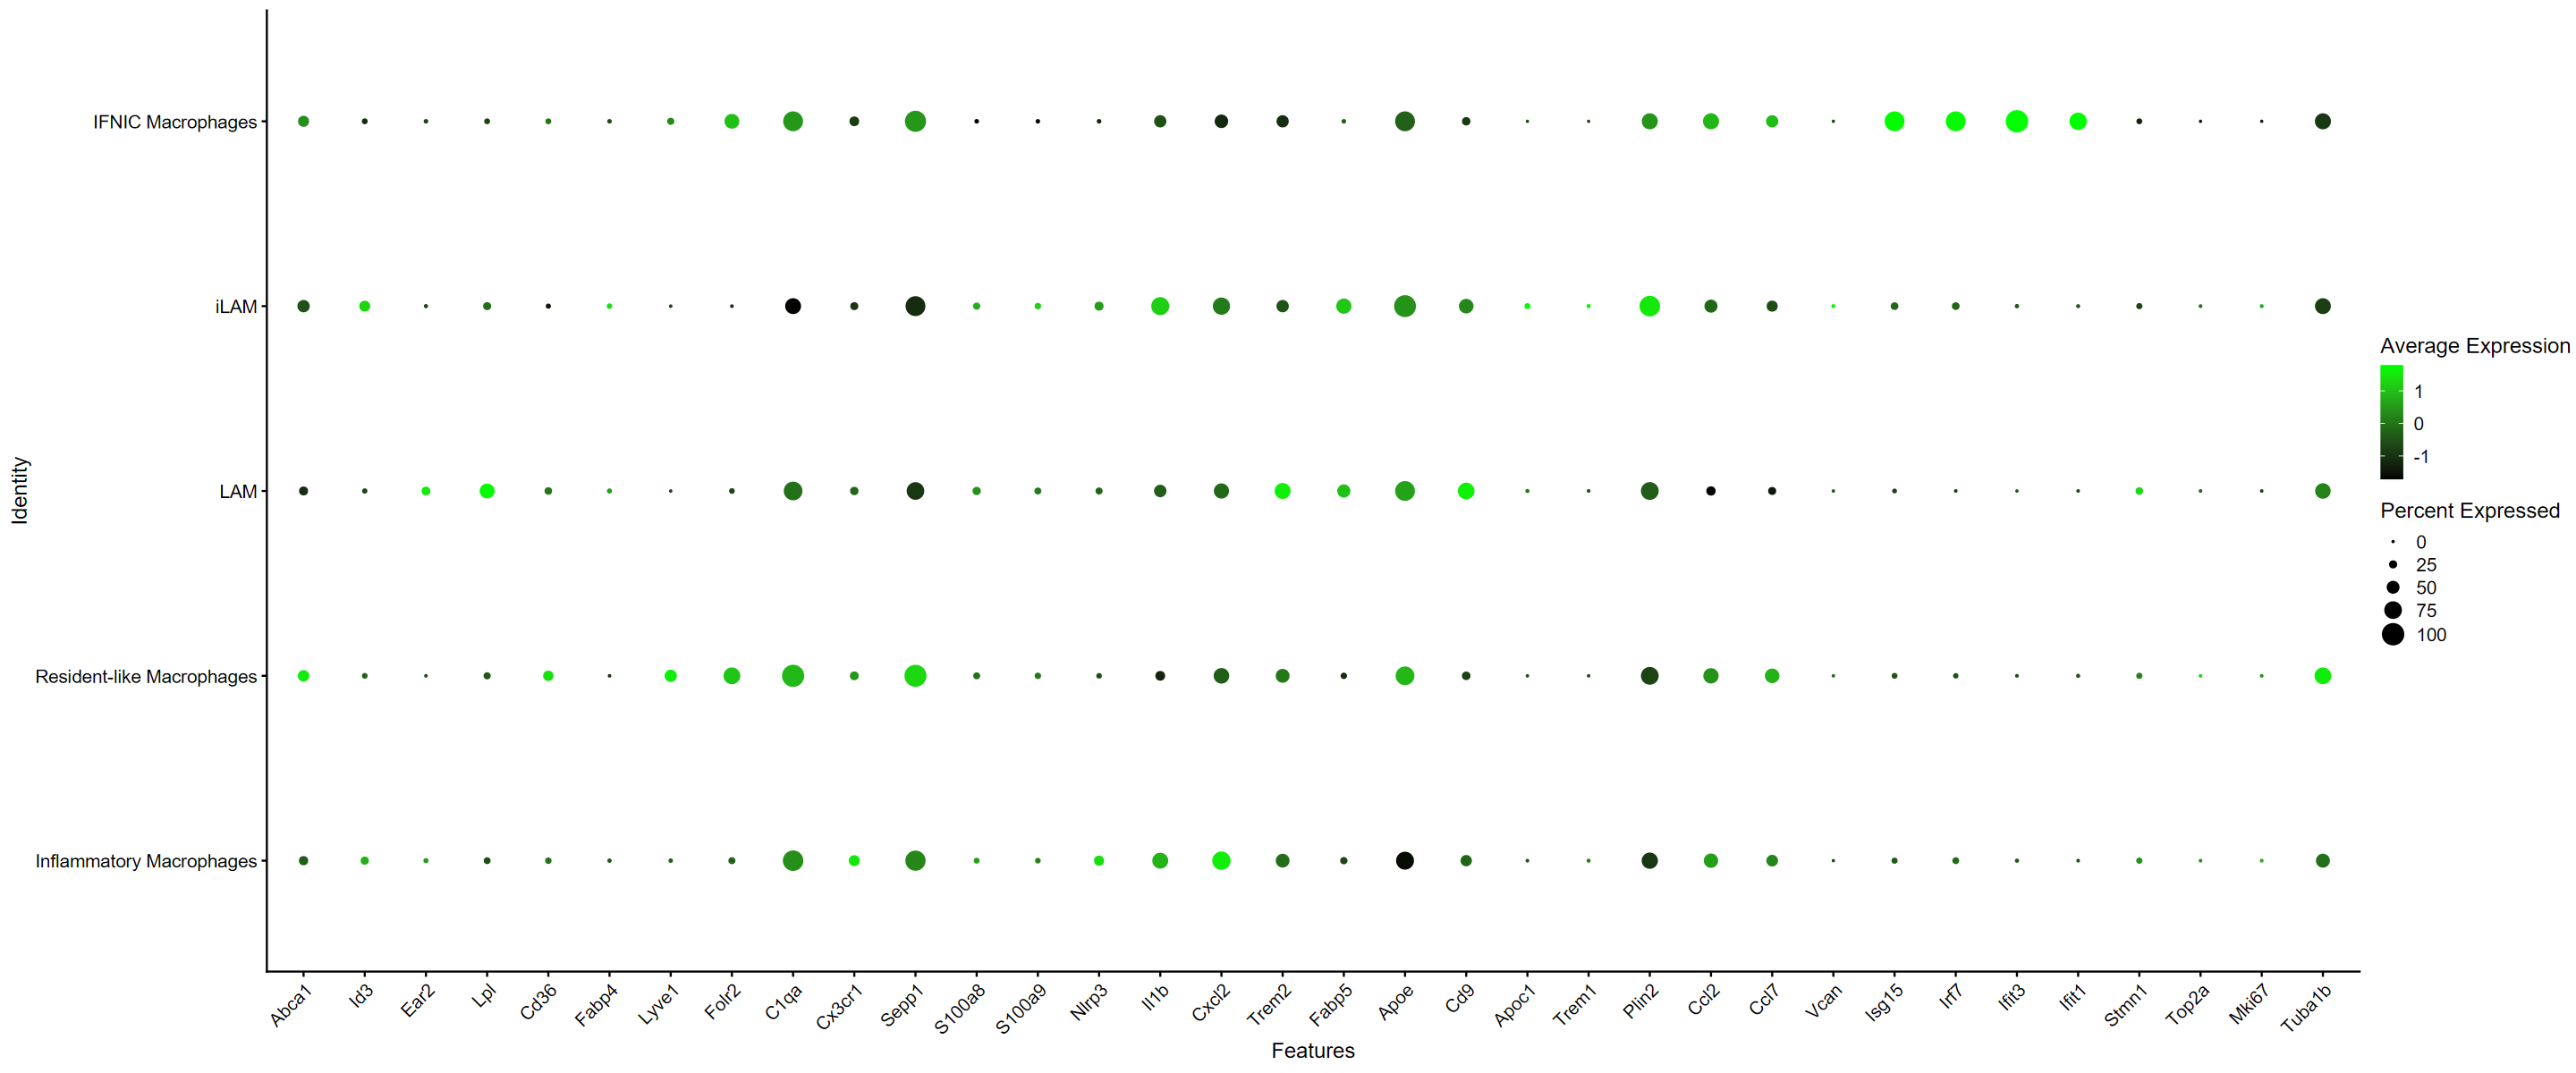

In [ ]:
# Dot plot of mouse markers
DotPlot(macrophages_m2, features = known_markers_m, cols = c("black", "green")) + RotatedAxis()

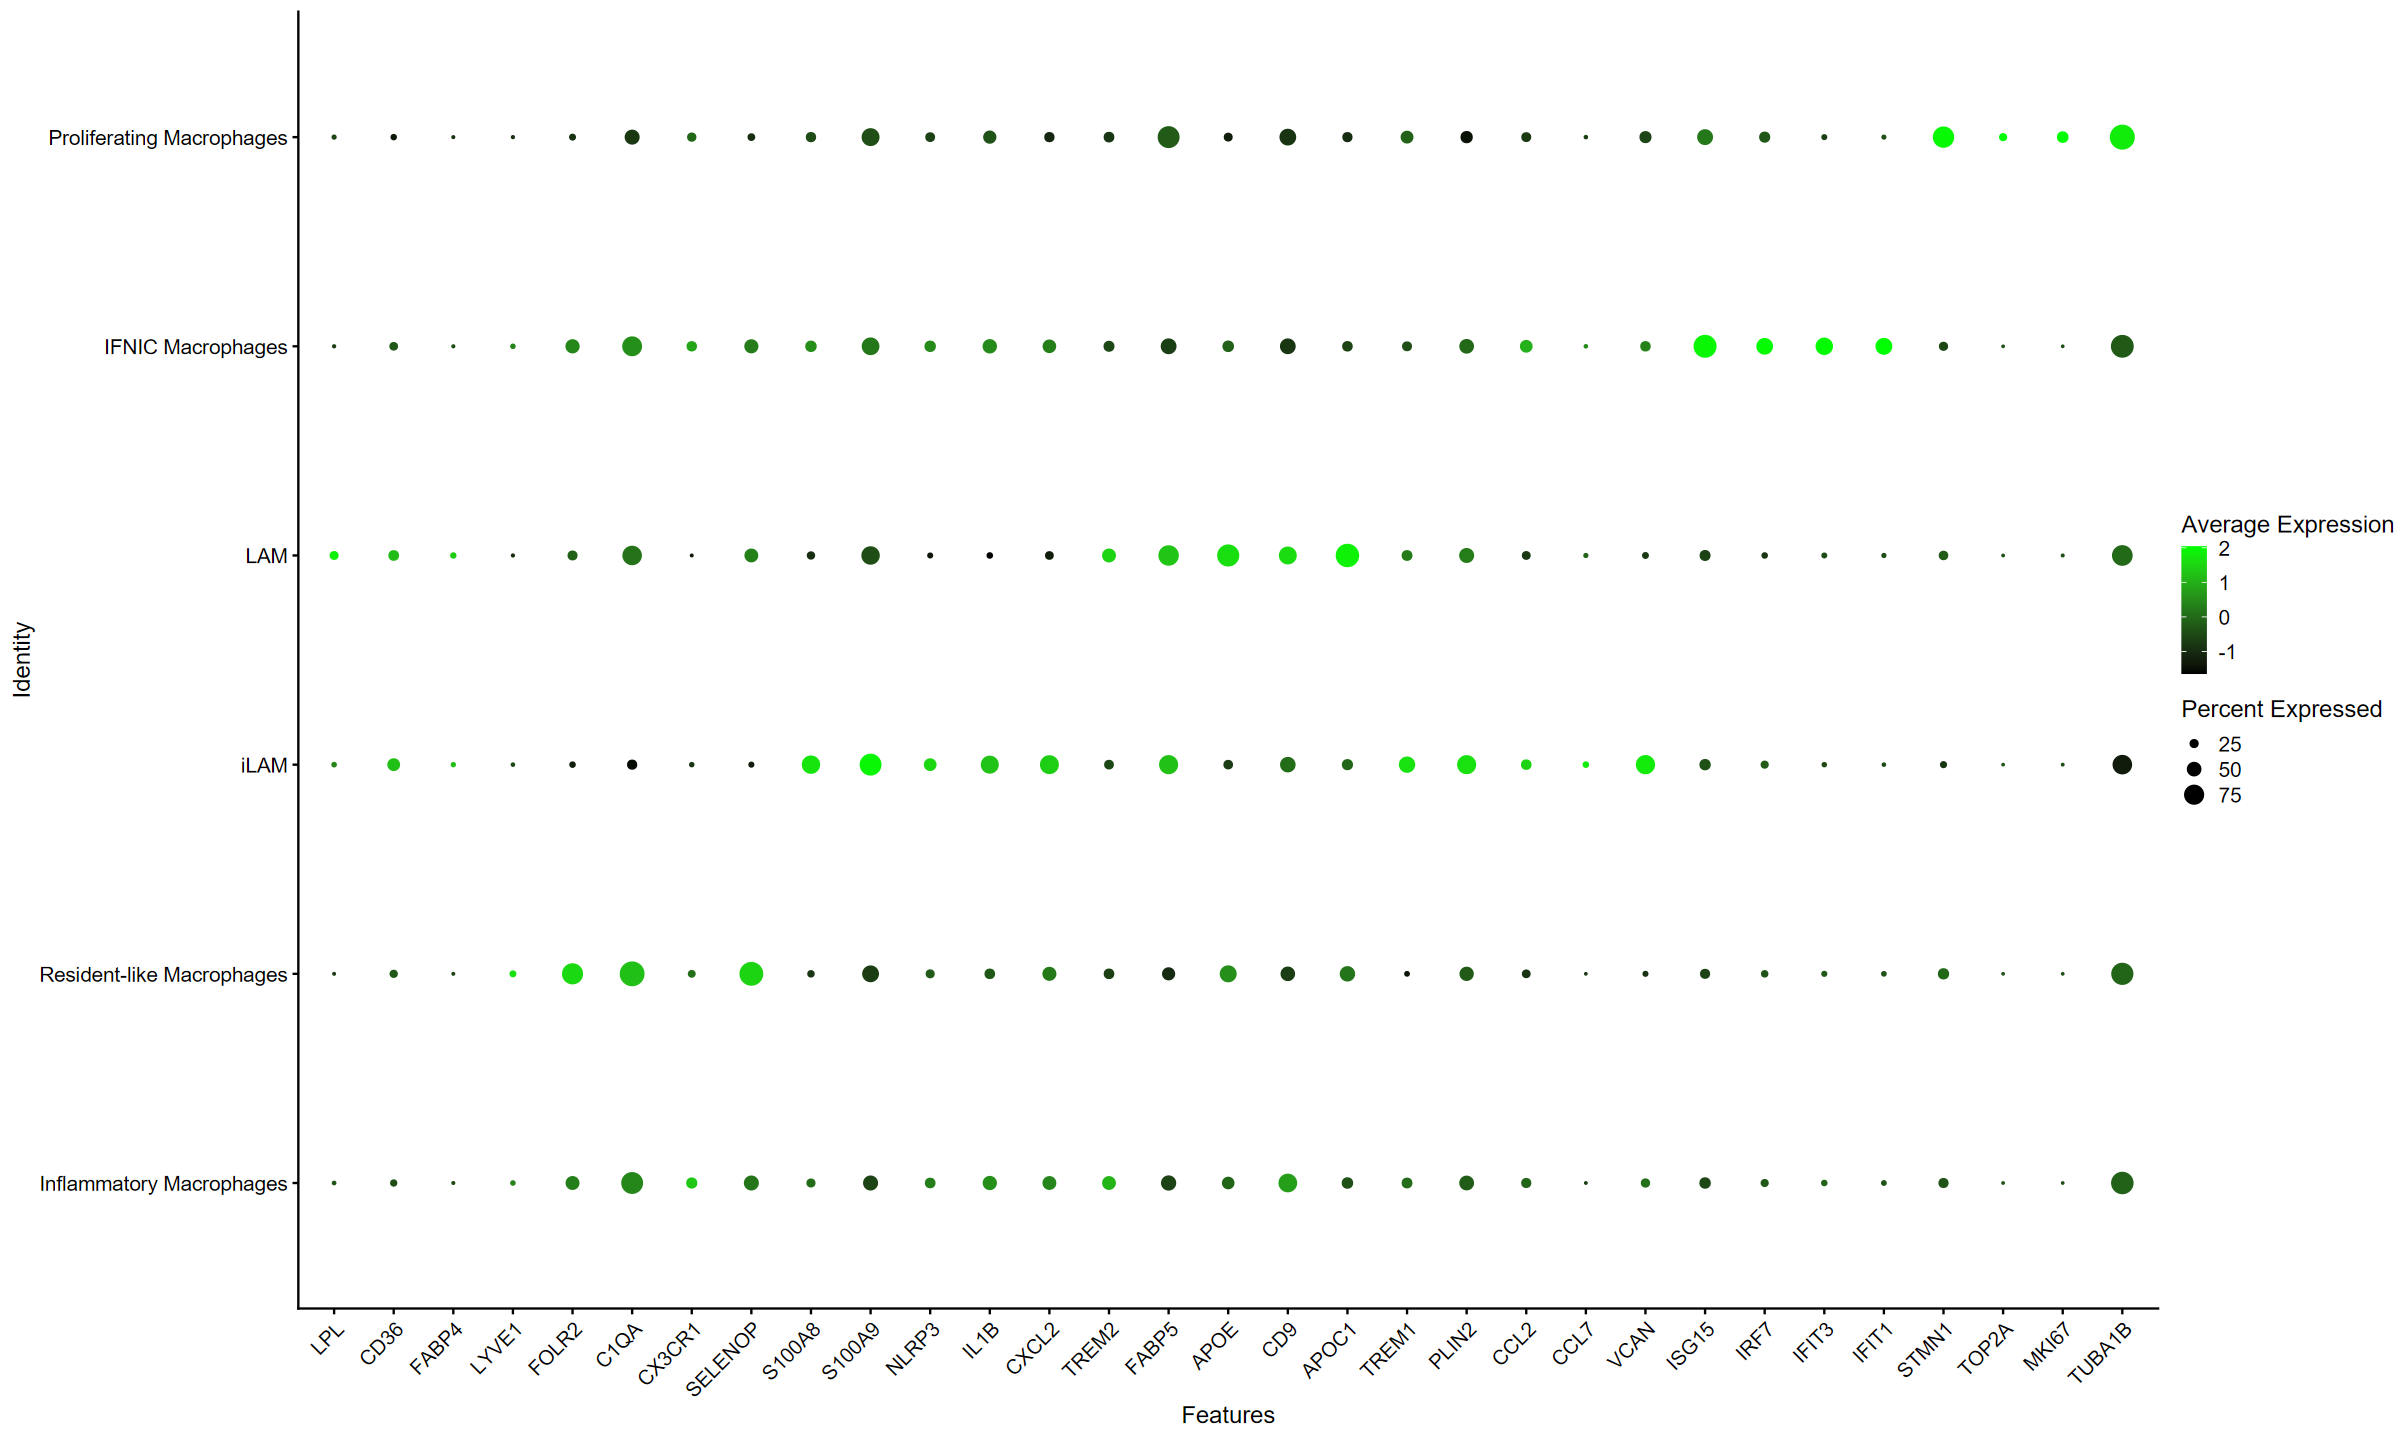

In [ ]:
# Dot plot of human markers
DotPlot(macrophages_h2, features = known_markers_h, cols = c("black", "green")) + RotatedAxis()

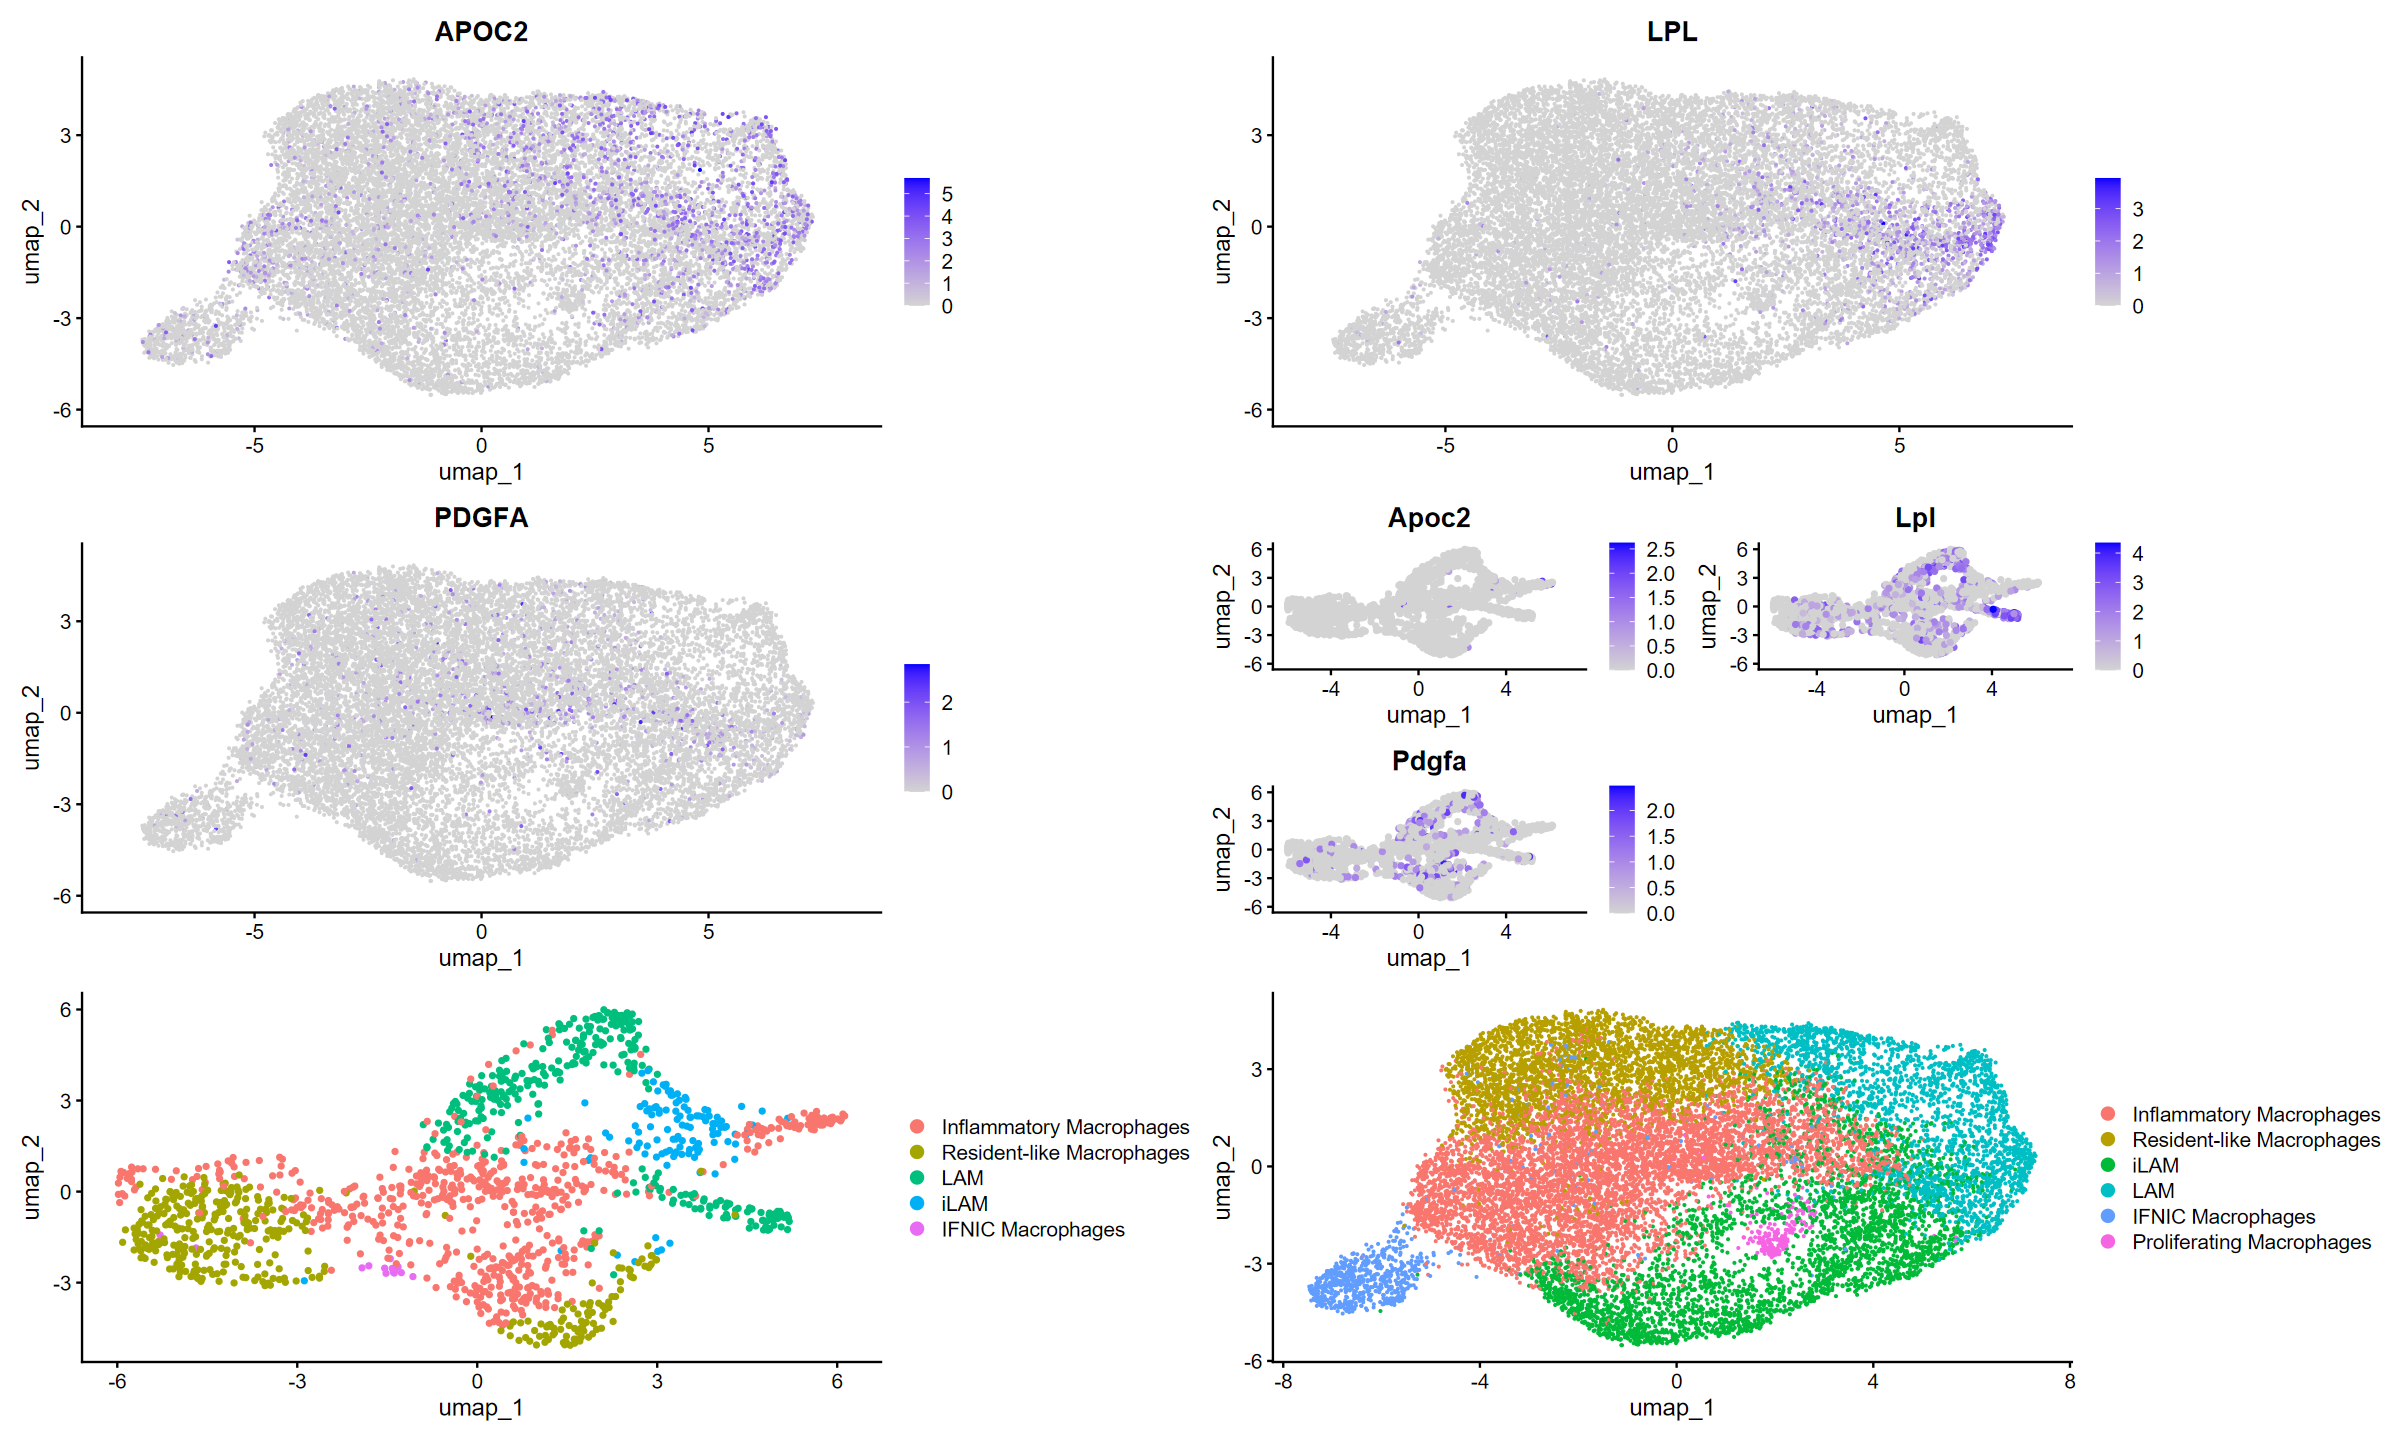

In [ ]:
# Feature plot of APOC2, LPL and PDGFA
FeaturePlot(object = macrophages_h2,reduction = "umap", features = c("APOC2", "LPL", "PDGFA")) + FeaturePlot(object = macrophages_m2,reduction = "umap", features = c("Apoc2", "Lpl", "Pdgfa")) + DimPlot(object = macrophages_m2, reduction = "umap") + DimPlot(object = macrophages_h2, reduction = "umap")

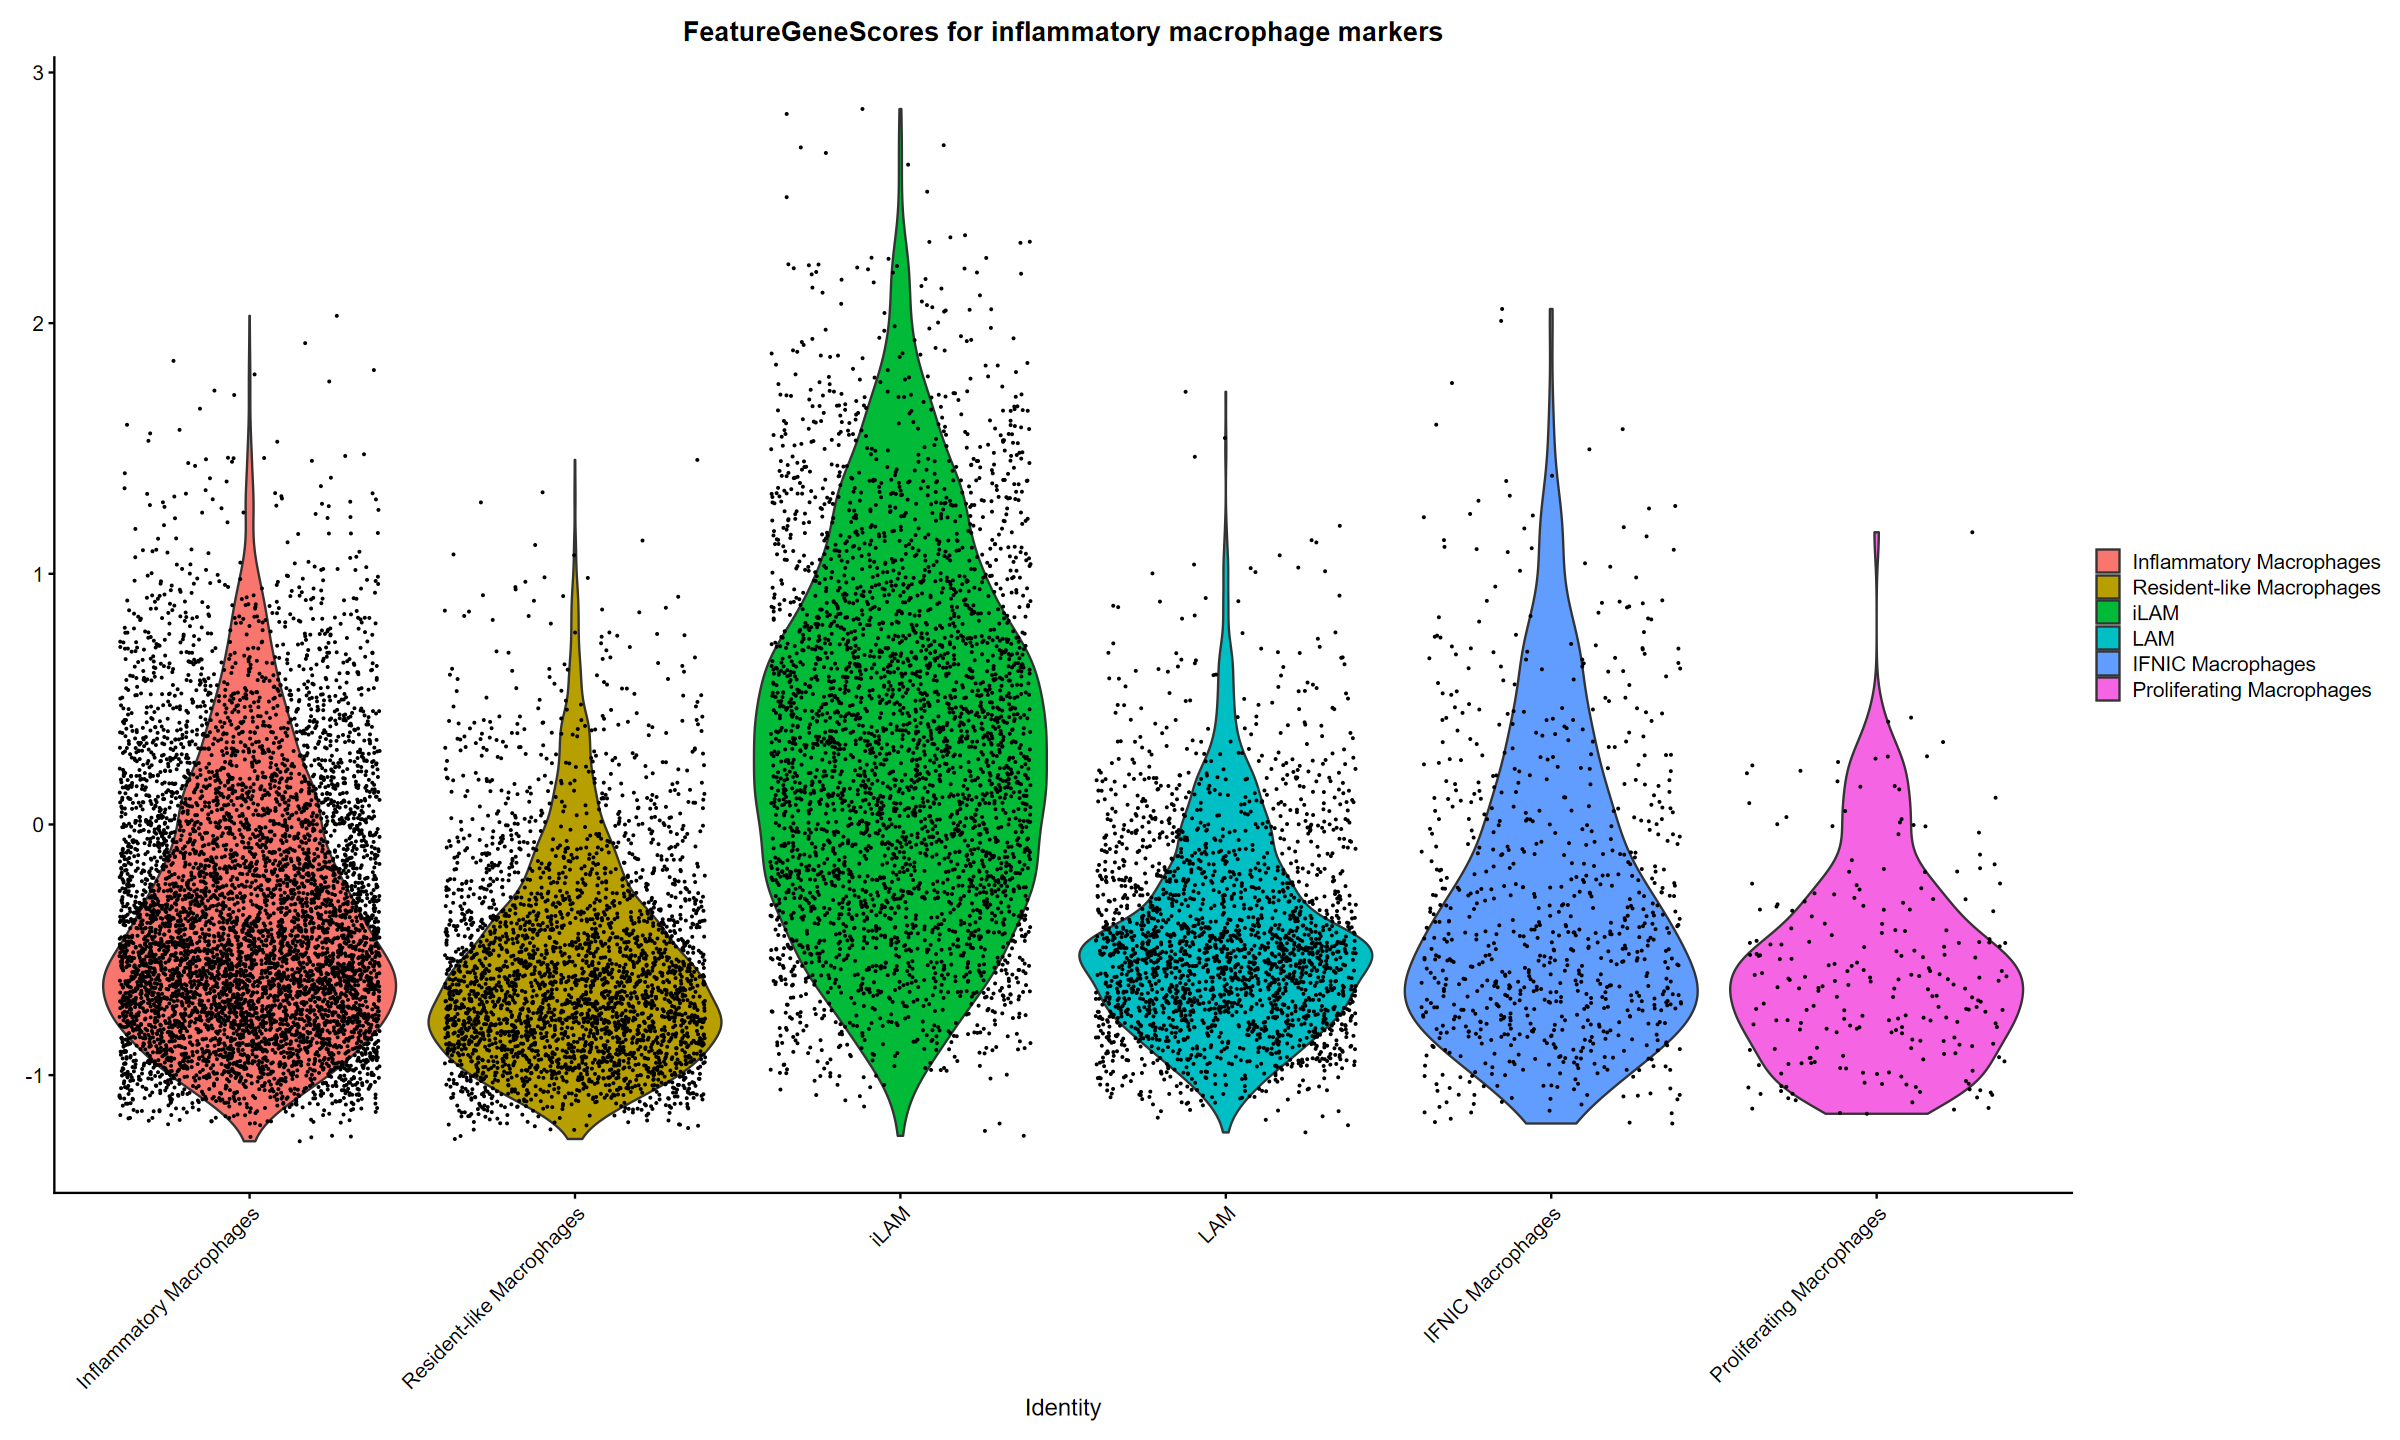

In [ ]:
# Violin plot of inflammatory violin
macrophages_h2 <- AddModuleScore(macrophages_h2, features = list(markers_ilams), name = "FeatureGeneScore_ilam")
inflammatory_vln <- VlnPlot(macrophages_h2, features = "FeatureGeneScore_ilam1") + 
  ggtitle("FeatureGeneScores for inflammatory macrophage markers")

# Plot inflammatory violin
inflammatory_vln